In [ ]:
from torch.utils.data import DataLoader
from torchvision.datasets import VisionDataset
import torch
from torch.utils.data import Dataset
from torchvision import transforms
from torchvision.transforms import ToTensor,Resize
import matplotlib.pyplot as plt
import zipfile 
import numpy as np 
import matplotlib.pyplot as plt 
import os

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
z = zipfile.ZipFile('/content/drive/MyDrive/Colab Notebooks/IVC_Network.zip', 'r')
z.extractall()

In [ ]:
# z = zipfile.ZipFile('/content/Eval.zip', 'r')
# z.extractall()

In [ ]:
root_dir = "main_dir"
os.listdir(root_dir)

['train', 'val']

In [ ]:
transforms = transforms.Compose([
                                 ToTensor(),])

In [ ]:
train_data = VisionDataset(root = os.path.join(root_dir,'train'),
                         transform= transforms)

In [ ]:
import os
import pandas as pd
from torchvision.io import read_image
import torch
from torch.utils.data import Dataset
from torchvision import datasets
import glob
import random


class My_class(Dataset):
    def __init__(self,  data_dir, transforms=None, target_transform=None):
        #print(glob.glob(data_dir))
        self.labels = []
        self.xy = []
        self.Parameters = []
        self.transform = transforms
        for i, dir in enumerate(glob.glob(data_dir)):
            for name in glob.glob(dir+"/*"):
              self.labels.append(i)
            
              with open(name) as file:
                line = file.readlines()
                x = line[0].split(sep = ";")
                X = list(map(float,x))
                y = line[2].split(sep = ";")
                Y = list(map(float,y))
                # param = line[4].split(sep = ";")
                # param = list(map(float,param))
                # self.Parameters.append(param)
                self.xy.append((X,Y))
                #print(param)

    def __len__(self):
        return len(self.xy)

    # def getparemeters(self, idx):

    #     return np.array(self.Parameters[idx])

    def __getitem__(self, idx):
        #image = self.transforms(self.image) 
        XY = np.array(self.xy[idx])

        
        #print(Norm) 

        # XY[1] = np.array(self.xy[idx])[1] * random.randrange(1, 100, 1) / random.randrange(1, 100, 1) 
        # XY[0] = np.array(self.xy[idx])[0] * random.randrange(1, 50, 1) / random.randrange(1, 50, 1) 

        #print(XY)
        # Normx =np.amax(np.absolute(XY[1]))
        # Normy =np.amax(np.absolute(XY[0]))
        XY[1] = XY[1] / (12/4750)
        XY[0] = XY[0] / 12
        # print(XY[1])
        # print(XY[0])
        if self.transform==None:
           return XY.astype(np.float32), self.labels[idx]
        else:
           return self.transform(XY.astype(np.float32)), self.labels[idx]
       

In [ ]:
dataset_train = My_class("/content/main_dir/train/*",transforms)
dataset_val = My_class("/content/main_dir/val/*",transforms)
dataset_Eval = My_class("/content/Eval/*",transforms)

In [ ]:
train_loader = DataLoader(dataset_train, batch_size=10000, shuffle= True,
                        )

val_loader = DataLoader(dataset_val, batch_size=10000, shuffle= True,                       
                        )

Eval_loader = DataLoader(dataset_Eval, batch_size=25, shuffle= True,  
                         )

In [ ]:
# train_loader = iter(train_dataset)
# val_loader = iter(train_loader)
# next(train_loader)
# next(val_loader)

In [ ]:
import torch.nn as nn
import torch
import torch.nn.functional as F

class TwoLayerCNN(nn.Module):

    def __init__(self):

        super().__init__() 
        self.net = torch.nn.Sequential(
            nn.Linear(200,100),
            #nn.BatchNorm1d(100),
            nn.ReLU(),
            #nn.Sigmoid(),

            nn.Linear(100,50),
            # #nn.BatchNorm1d(50),
            nn.ReLU(),
            #nn.Sigmoid(),

            nn.Linear(50,20),
            # #nn.BatchNorm1d(20),
            nn.ReLU(),
            #nn.Sigmoid(),
            
            nn.Linear(20,15),

            #  nn.Conv2d(3,6,3),
            #  nn.ReLU(),
            #  nn.MaxPool3d(2, stride=2),
            #  nn.Flatten(),
            #  nn.Linear(675,10),
                           )

      
    def forward(self, x):
        #print(x.shape)
        # print(x)
        # print('\n')
        # print(x[0][0][0])
        # print('\n')
        x = x.view(-1,200)
        #print(x.shape)
        x = self.net(x)
    
        return x

In [ ]:
import torch.optim as optim

def validate(model,testloader):
    correct = 0
    total = 0
    with torch.no_grad():
        for xy, labels in testloader:
            #xy, labels = xy.cuda(), labels.cuda()
            outputs = model(xy)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return correct / total

In [ ]:
def train(model, loss_function,optimizer , epochs):
    loss_test = []
    loss_hist = []
    acc_train = []
    acc_test = []
    acc_testReal = []
    for epoch in range(epochs):
        ep_loss = 0
        ep_loss1 = 0
        # print("dasdsd")
        for xy, labels in train_loader: # get bacth
            #xy, labels = xy.cuda(), labels.cuda()
            # print("dadsadasdsdsd")         
            optimizer.zero_grad() # sets the gradients of all optimized tensors to zero.
            outputs = model(xy) # call forward inside 
            loss = loss_function(outputs, labels) # calculate loss
            loss.backward() # calculate gradients
            optimizer.step() # performs a single optimization step (parameter update).
            ep_loss += loss.item()
        loss_hist.append(ep_loss)
        #print(loss_hist.append(ep_loss))

            #print("22sdsd")
        
          
        for xy, labels in val_loader:
            #xy, labels = xy.cuda(), labels.cuda()
            outputs = model(xy)
            loss1 = loss_function(outputs, labels)
            #loss1.backward()
            ep_loss1 += loss1.item()
        loss_test.append(ep_loss1)
        
        acc = validate(model, val_loader)
        accE = validate(model, Eval_loader)
        acc_train.append(validate(model, train_loader))
        acc_test.append(acc)
        acc_testReal.append(accE)
        #print(loss_test)

        if epoch % 1 == 0:
          print("Epoch: %d    loss_train: %1.5f    loss_test: %1.5f    acc_test: %1.5f%%     Real Data: %1.0f%%" % (epoch, ep_loss,ep_loss1, acc*100, accE*100))
          #print(ep_loss)
        # print(validate(model, train_loader))
        # print("d")
        # print(validate(model, val_loader))
        #print(f"Epoch={epoch} loss= {loss_hist[epoch]:.4}   loss_test= {loss_test[epoch]:.4}     Accuracy train= {acc_train[epoch]:.4}     Accuracy test= {acc_test[epoch]:.4}  ")
    #accuracy = validate(model, testloader)
    #
    return loss_hist, loss_test, acc_train, acc_test, acc_testReal

In [ ]:
model = TwoLayerCNN()#.cuda()

In [ ]:
optimizer = optim.Adam(model.parameters(),
                       lr=3e-2)    #5e-2
epochs= 50
#accuracy, loss_his, loss_test, acc_train, acc_test = train(model, nn.CrossEntropyLoss(), optimizer, epochs )
loss_his, loss_test, acc_train, acc_test, acc_testReal = train(model, nn.CrossEntropyLoss(), optimizer, epochs )

Epoch: 0    loss_train: 31.52301    loss_test: 24.68554    acc_test: 27.76370%     Real Data: 36%
Epoch: 1    loss_train: 22.65620    loss_test: 20.90396    acc_test: 36.03778%     Real Data: 32%
Epoch: 2    loss_train: 18.61497    loss_test: 19.81092    acc_test: 40.54593%     Real Data: 32%
Epoch: 3    loss_train: 18.46725    loss_test: 16.22824    acc_test: 49.67852%     Real Data: 32%
Epoch: 4    loss_train: 15.20754    loss_test: 19.09222    acc_test: 47.37333%     Real Data: 36%
Epoch: 5    loss_train: 16.40161    loss_test: 14.37791    acc_test: 53.83630%     Real Data: 36%
Epoch: 6    loss_train: 13.65033    loss_test: 12.67437    acc_test: 59.63259%     Real Data: 32%
Epoch: 7    loss_train: 15.58259    loss_test: 15.65952    acc_test: 52.00222%     Real Data: 44%
Epoch: 8    loss_train: 14.24912    loss_test: 13.35434    acc_test: 57.20074%     Real Data: 40%
Epoch: 9    loss_train: 12.48572    loss_test: 12.77448    acc_test: 60.42000%     Real Data: 44%
Epoch: 10    loss_tr

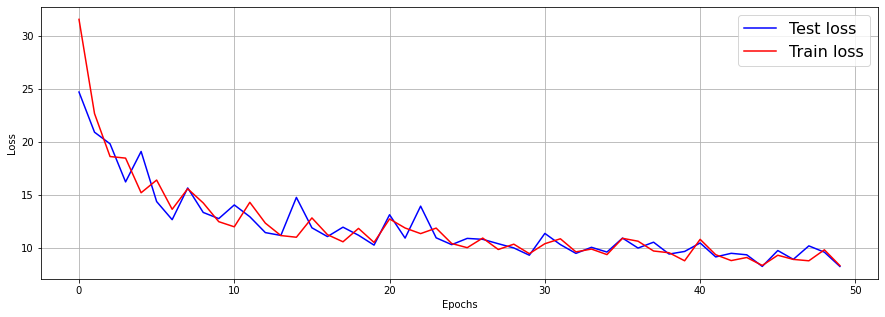

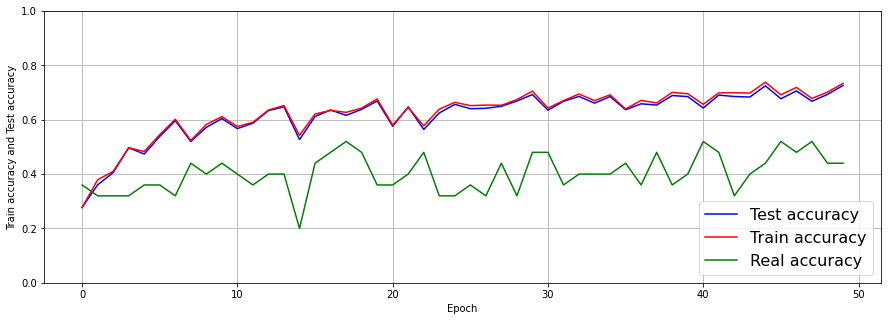

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(range(epochs), loss_test, color="blue", label="Test loss")
ax.plot(range(epochs), loss_his, color="red", label="Train loss")
ax.legend(loc=1, prop={'size': 16}) 
plt.xlabel("Epochs")
plt.ylabel("Loss")
#plt.ylim([0, 10])
plt.grid(True)
plt.show()

fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(range(epochs), acc_test, color="blue", label="Test accuracy")
ax.plot(range(epochs), acc_train, color="red", label="Train accuracy")
ax.plot(range(epochs), acc_testReal, color="green", label="Real accuracy")
ax.legend(loc=4, prop={'size': 16}) 

plt.xlabel("Epoch")
plt.ylabel("Train accuracy and Test accuracy")
plt.ylim([0, 1])
plt.grid(True)
plt.show()

In [ ]:
from collections import Counter

class MyCounter(object):
    def __init__(self):
        self.x_values = Counter()
        self._x = None

    @property
    def x(self):
        return self._x

    @x.setter
    def x(self, x):
        self._x = x
        self.x_values[x] += 1


c = MyCounter()
c.x = 1
c.x = 2
c.x = 3
c.x = 3
c.x = 2
c.x = 1
c.x = 1

print(c.x_values)
print(sum(c.x_values))
# prints Counter({1: 3, 2: 2, 3: 2})

Counter({1: 3, 2: 2, 3: 2})
6


In [ ]:
classs=[]
for j, dir in enumerate(glob.glob('/content/main_dir/val/*')):
            for name in glob.glob(dir+""):
               parts = name.split('/')
               print(parts[4], end=' - ')
               print(j)
               #print('\n')
               classs.append(parts[4])
classignor = classs     

DDR - 0
DD - 1
DR1 - 2
DDCR - 3
CD - 4
CRD2 - 5
DDC - 6
C - 7
DR - 8
CRD4 - 9
CR1 - 10
D - 11
CRD3 - 12
R - 13
CRD1 - 14


In [ ]:
General_param_errR = []
General_param_errC = []
General_acc_err = []
 # количество параметров в классе

def Err_par(dir,items=200):
  items +=1
  acc_err = []
  one_param = []
  param_errC = []
  param_errR = []
  param_err = []
  xy_Err= []
  c = MyCounter()
  dir1 = '/content/main_dir/val/' + dir+'/'+dir+ "_"
  for i in range(len(classs)):
    if classs[i] == dir:
      classes = i
      print(classs[i])
      print(i)
  for i in range(1,items,1):
    XY_err = []  
    one_param=(glob.glob(f"{dir1}{i}_*"))
    with open(f"{dir1}{i}_1_0.txt") as file:
      line = file.readlines()
      param = line[4].split(sep = ";")
      param = list(map(float,param))
    param_err.append(param[0:2])
    param_errR.append(param[0:1])
    param_errC.append(param[1:2])
    
    #print(len(one_param))
    for j in one_param:
      #print(j)
      with open(j) as file:
        line = file.readlines()
        x = line[0].split(sep = ";")
        X = list(map(float,x))
        y = line[2].split(sep = ";")
        Y = list(map(float,y))
      X = np.array(X)
      Y = np.array(Y)
      xy_t = []
      xy_t = np.array((X,Y))
      Normx =(12)
      Normy =(12/4750)
      xy_t[1] = xy_t[1] / Normy
      xy_t[0] = xy_t[0] / Normx
      xy_test = transforms((xy_t).astype(np.float32))
      XY_err.append(xy_test)
    xy_Err.append(XY_err)
  General_param_errC.extend(param_errC)
  General_param_errR.extend(param_errR)
  #print(len(param_errR))

  #j0 = 4800 # число вахов с одними параметрами j0+l0
  # print(len(xy_Err))
  # print(len(XY_err))
  #print()
  for k0 in range(len(param_err)):
    k = 0
    j0 = len(xy_Err[k0])
    for i in range(j0):
      #print(f'{k0}    {i}')
      #print(i)
      outputs = model(xy_Err[k0][i])
      max_elements, max_idxs = torch.max(outputs, dim=1)
      j = int(max_idxs[0])
      # print(classes)
      #print(j)
      # print('\n')
      c.x = j
      if j == classes: # если равно номеру класса то угадали
        
        k = k + 1
        
      #print(k)
    # print(k)
    # print(j0)
    # print('\n')
  
    acc_err.append((k/j0+0.01))
  #print(xy_Err[48][4])
  General_acc_err.extend(acc_err)
  print(acc_err)
  print(c.x_values)
  fig = plt.figure(figsize=(10, 6))
  ax = fig.add_subplot(1, 1, 1)
  colors = np.array(acc_err)
  S = np.array(acc_err)
  plt.grid(True)
  plt.scatter(np.array(param_errR), np.array(param_errC),s =100, c=colors, alpha=0.7)
  ax.set_yscale('log')
  ax.set_xscale('log')
  plt.colorbar()
  plt.show()
  

In [ ]:
#classignor.remove('CR1')

In [ ]:
#classignor.remove('R')

In [ ]:
#classignor.remove('CRD3')

In [ ]:
#classignor.remove('CRD4')

In [ ]:
#classs.remove('D')

In [ ]:
#classs.remove('CRD1')

DDR
0
[0.9766666666666667, 0.61, 0.9433333333333334, 1.01, 1.01, 0.7266666666666667, 1.01, 0.71, 0.81, 0.9766666666666667, 1.01, 0.9766666666666667, 0.86, 0.9766666666666667, 0.8933333333333333, 0.81, 0.9266666666666666, 0.9766666666666667, 1.01, 0.9433333333333334, 0.86, 0.7933333333333333, 0.6766666666666666, 0.86, 0.5766666666666667, 1.01, 0.81, 0.81, 0.71, 0.96, 0.8266666666666667, 0.96, 0.6766666666666666, 0.56, 0.9266666666666666, 0.9266666666666666, 0.9433333333333334, 0.96, 0.81, 0.86, 0.91, 0.8433333333333334, 1.01, 0.81, 0.7933333333333333, 0.91, 0.91, 0.9766666666666667, 0.9266666666666666, 0.8933333333333333, 0.91, 0.9933333333333333, 0.8933333333333333, 0.9766666666666667, 0.8766666666666667, 1.01, 0.9433333333333334, 1.01, 0.9266666666666666, 0.9766666666666667, 0.6266666666666667, 0.6766666666666666, 1.01, 1.01, 0.96, 0.66, 0.7266666666666667, 0.9433333333333334, 0.9933333333333333, 0.7933333333333333, 0.9433333333333334, 1.01, 0.81, 0.49333333333333335, 0.86, 0.99333333

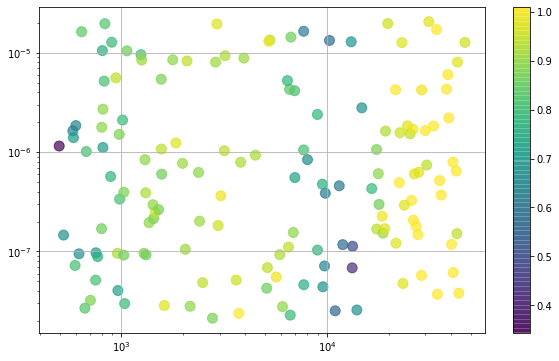

DD
1
[0.86, 0.9433333333333334, 0.8933333333333333, 0.9266666666666666, 0.9433333333333334, 0.9433333333333334, 0.91, 0.9266666666666666, 0.8766666666666667, 0.9433333333333334, 0.86, 0.9766666666666667, 0.8933333333333333, 0.86, 0.81, 0.8766666666666667, 0.9266666666666666, 0.8933333333333333, 0.8933333333333333, 0.9433333333333334, 0.9433333333333334, 0.8933333333333333, 0.9433333333333334, 0.8933333333333333, 0.91, 0.8933333333333333, 0.8933333333333333, 0.9266666666666666, 0.8933333333333333, 0.9433333333333334, 0.8766666666666667, 0.8433333333333334, 0.9433333333333334, 0.9433333333333334, 0.91, 0.91, 0.8433333333333334, 0.9266666666666666, 0.9433333333333334, 0.8766666666666667, 0.96, 0.9433333333333334, 0.96, 0.96, 0.8766666666666667, 0.9266666666666666, 0.96, 0.9433333333333334, 0.9266666666666666, 0.81, 0.91, 0.8933333333333333, 0.96, 0.96, 0.9266666666666666, 0.91, 0.9433333333333334, 0.9266666666666666, 0.91, 0.8933333333333333, 0.9766666666666667, 0.8766666666666667, 0.96, 

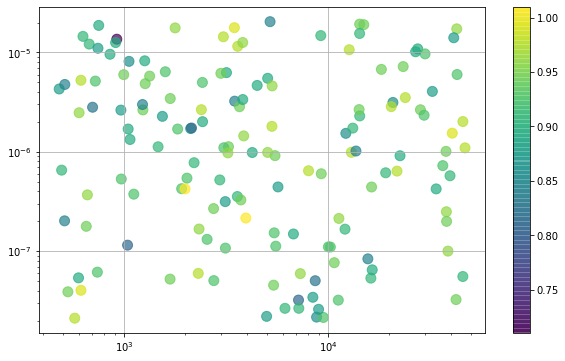

DR1
2
[0.9433333333333334, 1.01, 1.01, 0.8433333333333334, 0.9933333333333333, 0.9433333333333334, 1.01, 0.9933333333333333, 0.9933333333333333, 1.01, 0.9766666666666667, 1.01, 0.9933333333333333, 1.01, 0.9433333333333334, 1.01, 0.9766666666666667, 0.9266666666666666, 1.01, 0.9433333333333334, 0.9266666666666666, 0.91, 1.01, 0.91, 0.8433333333333334, 1.01, 0.9266666666666666, 0.8266666666666667, 0.96, 1.01, 0.96, 1.01, 0.9433333333333334, 0.96, 0.91, 0.91, 1.01, 0.91, 0.8766666666666667, 0.8766666666666667, 1.01, 0.8433333333333334, 1.01, 1.01, 1.01, 0.9433333333333334, 0.96, 1.01, 1.01, 1.01, 0.96, 1.01, 0.9433333333333334, 0.96, 0.9933333333333333, 0.9433333333333334, 1.01, 0.9766666666666667, 1.01, 0.8933333333333333, 0.9433333333333334, 0.9933333333333333, 1.01, 0.9433333333333334, 0.91, 1.01, 0.91, 0.8766666666666667, 0.9433333333333334, 0.91, 0.96, 1.01, 1.01, 0.91, 0.96, 0.96, 1.01, 0.9933333333333333, 1.01, 1.01, 0.9433333333333334, 0.8766666666666667, 0.9266666666666666, 1.01,

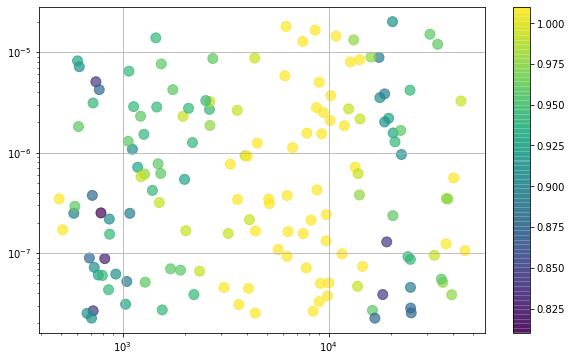

DDCR
3
[0.61, 0.17666666666666667, 0.27666666666666667, 0.9766666666666667, 0.5933333333333334, 0.026666666666666665, 0.7433333333333333, 0.61, 0.17666666666666667, 0.9266666666666666, 0.71, 0.27666666666666667, 0.44333333333333336, 0.8933333333333333, 0.4266666666666667, 0.5766666666666667, 0.043333333333333335, 0.21000000000000002, 0.91, 0.7766666666666667, 0.6933333333333334, 0.7266666666666667, 0.9266666666666666, 0.060000000000000005, 0.8933333333333333, 0.27666666666666667, 0.6433333333333333, 0.14333333333333334, 0.81, 0.6933333333333334, 0.37666666666666665, 0.5266666666666667, 0.14333333333333334, 0.9766666666666667, 0.41000000000000003, 0.96, 0.12666666666666668, 0.7433333333333333, 0.12666666666666668, 0.81, 0.11, 0.44333333333333336, 0.09333333333333332, 0.7933333333333333, 0.86, 0.9266666666666666, 0.3433333333333333, 0.7433333333333333, 0.6933333333333334, 0.6933333333333334, 0.8933333333333333, 0.31, 0.86, 0.24333333333333335, 0.5766666666666667, 0.71, 0.6766666666666666

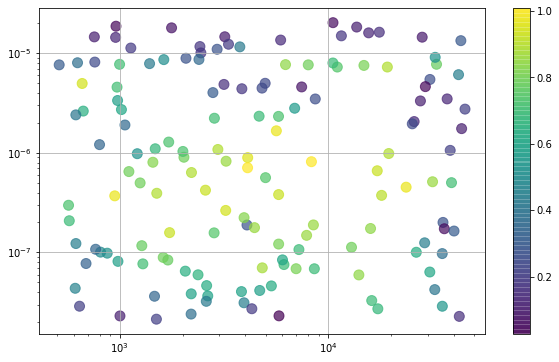

CD
4
[1.01, 1.01, 1.01, 1.01, 0.96, 0.27666666666666667, 0.7933333333333333, 0.8933333333333333, 1.01, 1.01, 1.01, 1.01, 1.01, 0.8933333333333333, 1.01, 0.41000000000000003, 1.01, 1.01, 0.86, 1.01, 0.21000000000000002, 0.8933333333333333, 1.01, 1.01, 1.01, 1.01, 1.01, 1.01, 0.21000000000000002, 0.4266666666666667, 1.01, 1.01, 1.01, 0.44333333333333336, 0.16, 1.01, 1.01, 1.01, 1.01, 0.6766666666666666, 0.44333333333333336, 0.14333333333333334, 1.01, 0.5266666666666667, 0.91, 1.01, 0.8266666666666667, 1.01, 0.96, 0.96, 0.36, 0.3433333333333333, 1.01, 0.37666666666666665, 1.01, 0.8933333333333333, 0.17666666666666667, 0.51, 1.01, 1.01, 0.3433333333333333, 1.01, 1.01, 1.01, 0.44333333333333336, 1.01, 1.01, 0.27666666666666667, 0.7933333333333333, 1.01, 0.81, 1.01, 1.01, 0.76, 1.01, 0.96, 0.37666666666666665, 1.01, 1.01, 1.01, 1.01, 0.8433333333333334, 0.76, 0.27666666666666667, 1.01, 1.01, 1.01, 0.3433333333333333, 0.9933333333333333, 1.01, 0.29333333333333333, 1.01, 1.01, 0.94333333333333

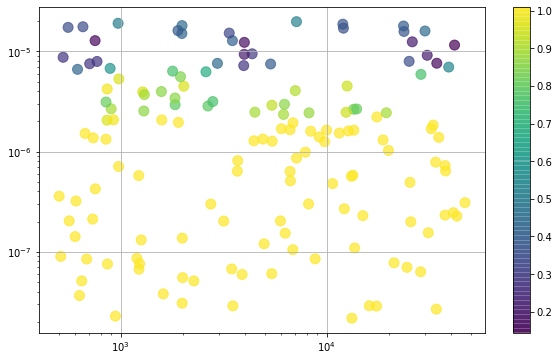

CRD2
5
[0.9433333333333334, 1.01, 0.5433333333333333, 0.7933333333333333, 0.7933333333333333, 0.8266666666666667, 0.8766666666666667, 0.8766666666666667, 0.49333333333333335, 0.4766666666666667, 0.41000000000000003, 1.01, 0.29333333333333333, 0.01, 1.01, 1.01, 0.8933333333333333, 0.76, 0.7766666666666667, 0.9933333333333333, 1.01, 0.86, 1.01, 0.9433333333333334, 0.01, 1.01, 0.01, 1.01, 1.01, 0.36, 0.8933333333333333, 0.86, 0.8433333333333334, 0.81, 0.24333333333333335, 0.9433333333333334, 0.9433333333333334, 0.7266666666666667, 0.060000000000000005, 1.01, 0.9933333333333333, 0.76, 0.96, 1.01, 0.026666666666666665, 0.01, 0.96, 0.46, 1.01, 0.8933333333333333, 1.01, 1.01, 0.026666666666666665, 0.01, 0.8266666666666667, 0.9266666666666666, 0.01, 0.01, 0.91, 0.6433333333333333, 0.7266666666666667, 0.46, 0.060000000000000005, 0.01, 1.01, 1.01, 0.8766666666666667, 0.91, 0.37666666666666665, 0.27666666666666667, 0.8766666666666667, 1.01, 0.9433333333333334, 1.01, 0.81, 1.01, 0.9433333333333334

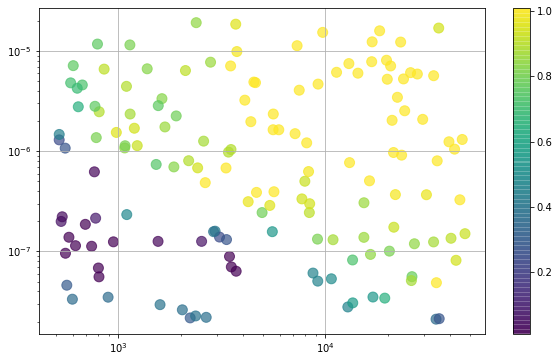

DDC
6
[0.24333333333333335, 0.11, 1.01, 1.01, 0.91, 1.01, 0.26, 0.21000000000000002, 0.24333333333333335, 0.66, 0.24333333333333335, 0.07666666666666666, 0.21000000000000002, 1.01, 0.7933333333333333, 0.32666666666666666, 0.9933333333333333, 0.24333333333333335, 0.9933333333333333, 0.32666666666666666, 0.24333333333333335, 0.19333333333333333, 0.81, 0.22666666666666668, 1.01, 1.01, 0.21000000000000002, 1.01, 0.51, 1.01, 0.11, 0.17666666666666667, 0.22666666666666668, 1.01, 0.07666666666666666, 1.01, 0.41000000000000003, 1.01, 1.01, 0.11, 0.26, 0.3433333333333333, 1.01, 1.01, 0.24333333333333335, 0.9766666666666667, 0.9933333333333333, 0.61, 1.01, 0.09333333333333332, 0.39333333333333337, 1.01, 0.7433333333333333, 0.6933333333333334, 0.81, 1.01, 0.9933333333333333, 1.01, 1.01, 1.01, 0.17666666666666667, 0.3433333333333333, 0.9933333333333333, 1.01, 0.61, 1.01, 0.17666666666666667, 1.01, 1.01, 0.8933333333333333, 0.6266666666666667, 1.01, 1.01, 0.9766666666666667, 0.7933333333333333, 0.2

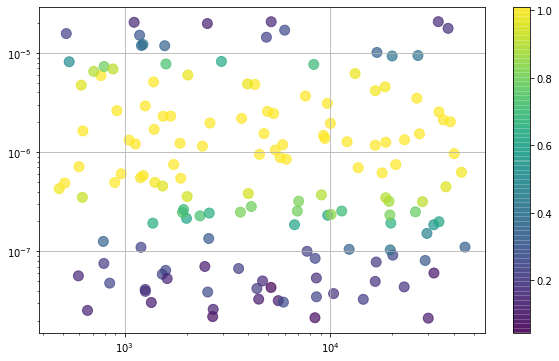

C
7
[0.76, 0.5266666666666667, 1.01, 0.26, 1.01, 1.01, 1.01, 1.01, 1.01, 0.6433333333333333, 1.01, 1.01, 0.6933333333333334, 1.01, 0.66, 1.01, 1.01, 0.6933333333333334, 1.01, 0.37666666666666665, 0.7433333333333333, 0.9433333333333334, 0.8433333333333334, 1.01, 1.01, 1.01, 1.01, 1.01, 0.27666666666666667, 1.01, 1.01, 0.29333333333333333, 1.01, 0.26, 0.31, 1.01, 1.01, 1.01, 0.6266666666666667, 1.01, 0.37666666666666665, 0.39333333333333337, 0.24333333333333335, 1.01, 0.9766666666666667, 0.9933333333333333, 0.61, 1.01, 0.66, 0.44333333333333336, 0.6766666666666666, 1.01, 1.01, 1.01, 1.01, 0.36, 1.01, 1.01, 1.01, 0.22666666666666668, 0.9433333333333334, 0.9933333333333333, 1.01, 0.24333333333333335, 0.5933333333333334, 0.86, 1.01, 1.01, 1.01, 1.01, 0.9766666666666667, 1.01, 1.01, 1.01, 0.41000000000000003, 1.01, 1.01, 1.01, 1.01, 1.01, 1.01, 1.01, 0.37666666666666665, 0.66, 1.01, 1.01, 0.7933333333333333, 0.3433333333333333, 1.01, 1.01, 0.71, 0.44333333333333336, 1.01, 0.66, 0.41000000000

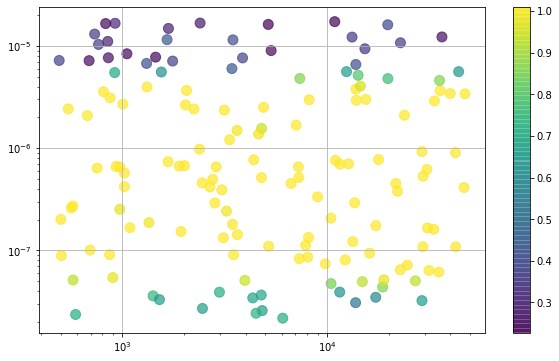

DR
8
[0.9266666666666666, 1.01, 0.8766666666666667, 0.9766666666666667, 1.01, 1.01, 0.9933333333333333, 1.01, 0.7266666666666667, 1.01, 1.01, 0.8433333333333334, 0.9766666666666667, 0.96, 0.8266666666666667, 0.9266666666666666, 1.01, 0.9933333333333333, 0.9266666666666666, 0.9933333333333333, 1.01, 0.8433333333333334, 0.86, 0.86, 0.91, 0.9433333333333334, 0.9433333333333334, 0.9933333333333333, 0.9433333333333334, 0.9433333333333334, 0.9266666666666666, 1.01, 0.7933333333333333, 0.96, 0.96, 1.01, 0.96, 1.01, 0.8933333333333333, 0.9766666666666667, 1.01, 0.91, 0.86, 0.91, 0.9266666666666666, 1.01, 0.96, 0.71, 0.9266666666666666, 0.8266666666666667, 0.9266666666666666, 0.9766666666666667, 0.9933333333333333, 0.9433333333333334, 0.76, 0.8766666666666667, 0.9933333333333333, 1.01, 0.9266666666666666, 1.01, 0.96, 0.8266666666666667, 0.9433333333333334, 0.9266666666666666, 1.01, 0.9266666666666666, 0.8766666666666667, 0.9266666666666666, 0.8933333333333333, 0.9766666666666667, 0.726666666666

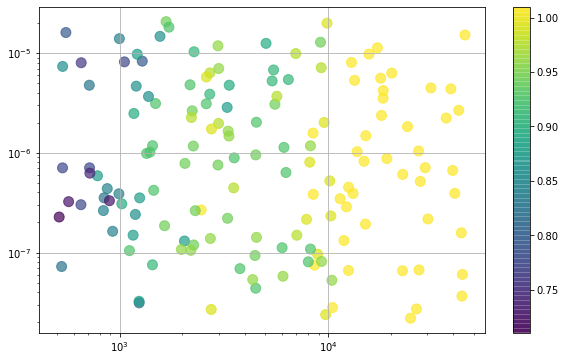

CRD4
9
[0.01, 0.21000000000000002, 0.11, 0.9766666666666667, 0.44333333333333336, 0.6266666666666667, 0.07666666666666666, 0.12666666666666668, 0.51, 1.01, 0.6266666666666667, 0.01, 0.09333333333333332, 0.026666666666666665, 0.026666666666666665, 0.043333333333333335, 0.56, 1.01, 0.060000000000000005, 0.6433333333333333, 0.71, 0.6766666666666666, 0.01, 0.6766666666666666, 0.21000000000000002, 0.026666666666666665, 0.16, 0.51, 0.22666666666666668, 0.4766666666666667, 0.12666666666666668, 0.026666666666666665, 0.01, 0.5766666666666667, 0.043333333333333335, 0.56, 0.01, 0.01, 0.5933333333333334, 0.043333333333333335, 0.01, 0.7266666666666667, 0.7933333333333333, 0.37666666666666665, 0.01, 0.5933333333333334, 0.16, 0.39333333333333337, 0.060000000000000005, 0.51, 0.07666666666666666, 0.29333333333333333, 0.56, 0.49333333333333335, 0.22666666666666668, 0.060000000000000005, 0.21000000000000002, 0.41000000000000003, 0.6933333333333334, 0.043333333333333335, 0.6933333333333334, 0.676666666666

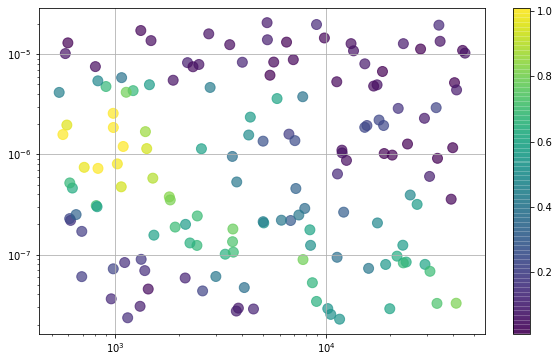

CR1
10
[0.16, 0.9266666666666666, 1.01, 0.9933333333333333, 0.4766666666666667, 0.01, 0.31, 0.61, 1.01, 0.49333333333333335, 0.76, 1.01, 0.44333333333333336, 0.01, 0.96, 0.41000000000000003, 0.66, 0.4266666666666667, 0.4766666666666667, 0.026666666666666665, 0.49333333333333335, 0.026666666666666665, 0.8433333333333334, 1.01, 0.4766666666666667, 0.3433333333333333, 0.9266666666666666, 1.01, 0.26, 0.46, 1.01, 1.01, 0.41000000000000003, 0.043333333333333335, 1.01, 0.3433333333333333, 0.26, 0.14333333333333334, 1.01, 0.6933333333333334, 0.16, 0.56, 0.32666666666666666, 0.026666666666666665, 0.91, 0.96, 0.6933333333333334, 0.01, 1.01, 1.01, 0.026666666666666665, 0.12666666666666668, 0.09333333333333332, 0.16, 0.026666666666666665, 0.060000000000000005, 0.01, 0.9433333333333334, 0.37666666666666665, 0.26, 0.01, 0.14333333333333334, 1.01, 0.01, 0.6766666666666666, 0.043333333333333335, 0.14333333333333334, 0.91, 1.01, 0.01, 0.19333333333333333, 0.4266666666666667, 0.39333333333333337, 0.1266

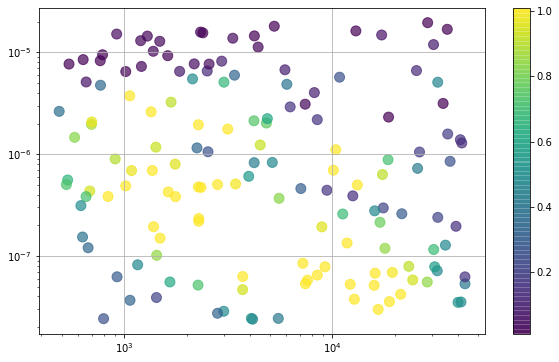

D
11
[1.01, 1.01, 1.01, 1.01, 1.01, 1.01, 1.01, 1.01, 1.01, 1.01, 1.01, 1.01, 1.01, 1.01, 1.01, 1.01, 1.01, 1.01, 1.01, 1.01, 1.01, 1.01, 1.01, 1.01, 1.01, 1.01, 1.01, 1.01, 1.01, 1.01, 1.01, 1.01, 1.01, 1.01, 1.01, 1.01, 1.01, 1.01, 1.01, 1.01, 1.01, 1.01, 1.01, 1.01, 1.01, 1.01, 1.01, 1.01, 1.01, 1.01, 1.01, 1.01, 1.01, 1.01, 1.01, 1.01, 1.01, 1.01, 1.01, 1.01, 1.01, 1.01, 1.01, 1.01, 1.01, 1.01, 1.01, 1.01, 1.01, 1.01, 1.01, 1.01, 1.01, 1.01, 1.01, 1.01, 1.01, 1.01, 1.01, 1.01, 1.01, 1.01, 1.01, 1.01, 1.01, 1.01, 1.01, 1.01, 1.01, 1.01, 1.01, 1.01, 1.01, 1.01, 1.01, 1.01, 1.01, 1.01, 1.01, 1.01, 1.01, 1.01, 1.01, 1.01, 1.01, 1.01, 1.01, 1.01, 1.01, 1.01, 1.01, 1.01, 1.01, 1.01, 1.01, 1.01, 1.01, 1.01, 1.01, 1.01, 1.01, 1.01, 1.01, 1.01, 1.01, 1.01, 1.01, 1.01, 1.01, 1.01, 1.01, 1.01, 1.01, 1.01, 1.01, 1.01, 1.01, 1.01, 1.01, 1.01, 1.01, 1.01, 1.01, 1.01, 1.01, 1.01, 1.01, 1.01, 1.01, 1.01]
Counter({11: 9000})


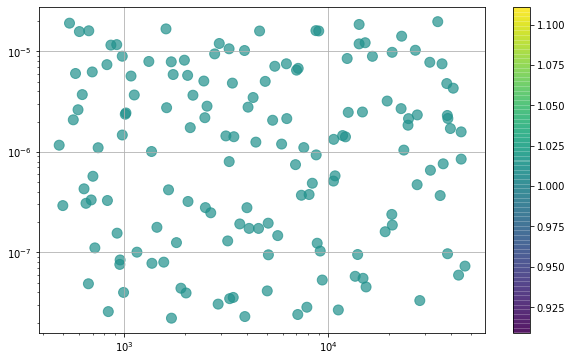

CRD3
12
[0.01, 1.01, 1.01, 0.01, 1.01, 1.01, 1.01, 0.043333333333333335, 1.01, 0.043333333333333335, 1.01, 1.01, 1.01, 0.7766666666666667, 0.01, 0.026666666666666665, 1.01, 0.07666666666666666, 0.31, 0.51, 1.01, 1.01, 1.01, 0.01, 1.01, 1.01, 1.01, 0.01, 1.01, 1.01, 0.9766666666666667, 0.01, 1.01, 0.9933333333333333, 0.026666666666666665, 1.01, 0.043333333333333335, 1.01, 0.91, 0.5433333333333333, 1.01, 0.043333333333333335, 0.39333333333333337, 0.026666666666666665, 1.01, 1.01, 0.51, 0.01, 0.91, 0.01, 1.01, 1.01, 0.060000000000000005, 1.01, 1.01, 1.01, 1.01, 1.01, 0.9766666666666667, 0.07666666666666666, 1.01, 0.8933333333333333, 0.3433333333333333, 1.01, 1.01, 1.01, 1.01, 1.01, 0.01, 0.8266666666666667, 0.01, 1.01, 0.39333333333333337, 0.36, 0.01, 1.01, 1.01, 0.01, 1.01, 1.01, 1.01, 1.01, 0.01, 0.026666666666666665, 1.01, 1.01, 1.01, 1.01, 1.01, 1.01, 0.56, 1.01, 1.01, 1.01, 0.01, 0.01, 1.01, 0.026666666666666665, 1.01, 1.01, 0.060000000000000005, 1.01, 1.01, 0.01, 0.6433333333333333,

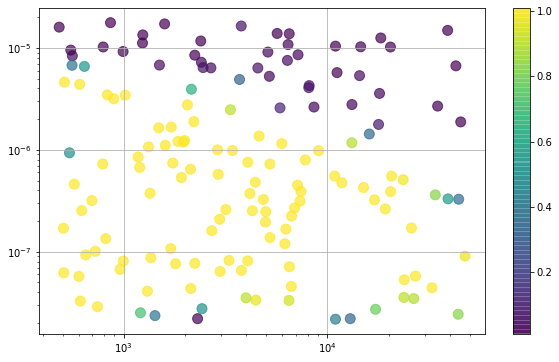

R
13
[0.01, 0.36, 0.01, 0.46, 0.01, 0.01, 0.043333333333333335, 0.01, 0.01, 0.01, 0.01, 0.36, 0.01, 0.01, 0.01, 0.6266666666666667, 0.37666666666666665, 0.01, 0.71, 0.01, 0.01, 0.86, 0.043333333333333335, 0.026666666666666665, 0.41000000000000003, 0.01, 0.4266666666666667, 0.01, 0.026666666666666665, 0.4266666666666667, 0.32666666666666666, 0.01, 0.41000000000000003, 0.8933333333333333, 0.01, 0.6933333333333334, 0.01, 0.01, 0.01, 0.19333333333333333, 0.44333333333333336, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.4766666666666667, 0.22666666666666668, 0.01, 0.01, 0.27666666666666667, 0.81, 0.81, 0.01, 0.01, 0.01, 0.01, 0.07666666666666666, 0.44333333333333336, 0.3433333333333333, 0.41000000000000003, 0.01, 0.3433333333333333, 0.16, 0.01, 0.01, 0.01, 0.11, 0.8433333333333334, 0.39333333333333337, 0.01, 0.81, 0.01, 0.026666666666666665, 0.01, 0.26, 0.41000000000000003, 0.043333333333333335, 0.01, 0.8433333333333334, 0.01, 0.060000000000000005, 0.19333333333333333, 0.49333333333333335, 0.37666

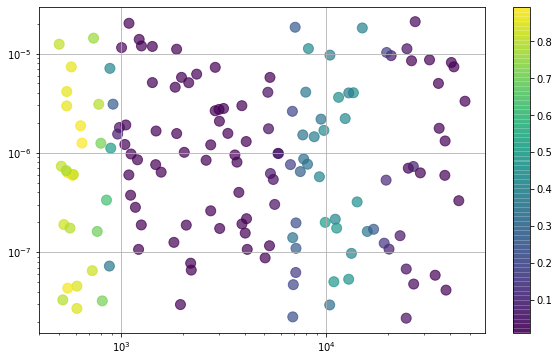

CRD1
14
[1.01, 0.86, 0.91, 1.01, 0.9433333333333334, 1.01, 1.01, 1.01, 1.01, 1.01, 1.01, 1.01, 1.01, 1.01, 0.91, 1.01, 0.9433333333333334, 1.01, 1.01, 1.01, 1.01, 1.01, 1.01, 1.01, 0.96, 1.01, 1.01, 0.9933333333333333, 0.043333333333333335, 1.01, 1.01, 1.01, 1.01, 1.01, 1.01, 0.9433333333333334, 1.01, 1.01, 1.01, 1.01, 1.01, 1.01, 1.01, 1.01, 1.01, 1.01, 0.16, 1.01, 1.01, 0.3433333333333333, 1.01, 1.01, 1.01, 1.01, 0.9933333333333333, 0.7933333333333333, 1.01, 1.01, 1.01, 1.01, 1.01, 1.01, 1.01, 1.01, 0.32666666666666666, 1.01, 0.9933333333333333, 1.01, 1.01, 0.7433333333333333, 1.01, 1.01, 1.01, 0.9433333333333334, 1.01, 1.01, 1.01, 1.01, 1.01, 1.01, 1.01, 1.01, 1.01, 0.7766666666666667, 1.01, 1.01, 1.01, 1.01, 1.01, 1.01, 1.01, 0.96, 1.01, 1.01, 0.09333333333333332, 1.01, 1.01, 1.01, 1.01, 1.01, 0.86, 1.01, 1.01, 1.01, 1.01, 0.32666666666666666, 1.01, 1.01, 1.01, 1.01, 1.01, 1.01, 1.01, 1.01, 1.01, 1.01, 1.01, 1.01, 1.01, 0.9933333333333333, 1.01, 1.01, 1.01, 1.01, 1.01, 1.01, 1.01, 

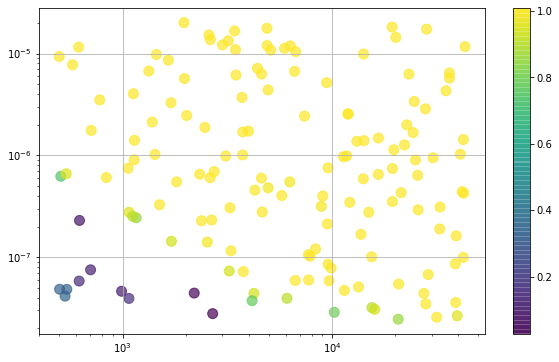

In [ ]:
items = 150
for name in classs:
  Err_par(dir=f"{name}",items=items)

Accurace of dataset_test 74.09917971662908%


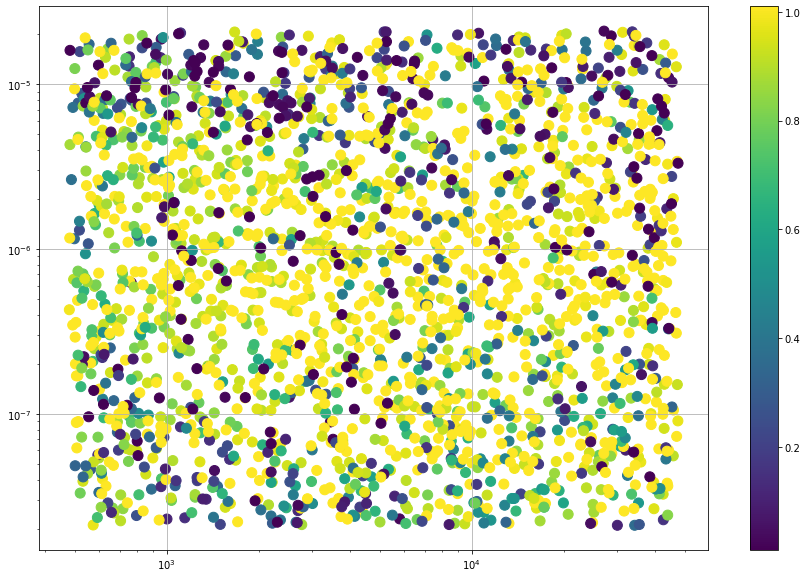

In [ ]:

print(f'Accurace of dataset_test {100*sum(General_acc_err)/((items-1)*len(classs))}%')
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(1, 1, 1)
#ax.set_facecolor("yellow")
colors = np.array(General_acc_err)
S = np.array(General_acc_err)
plt.grid(True)
plt.scatter(np.array(General_param_errR), np.array(General_param_errC),s=100, c=colors, alpha=1)
#plt.scatter(np.array(General_param_errR), np.array(General_param_errR),s =S*1000, c=colors, alpha=0.3)
ax.set_yscale('log')
ax.set_xscale('log')
plt.colorbar()
plt.show()


Accurace = 10%


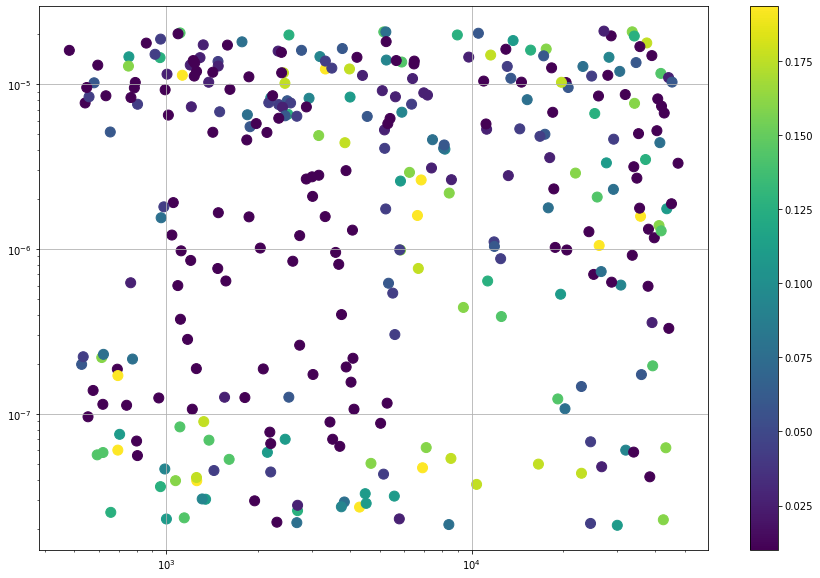

Accurace = 20%


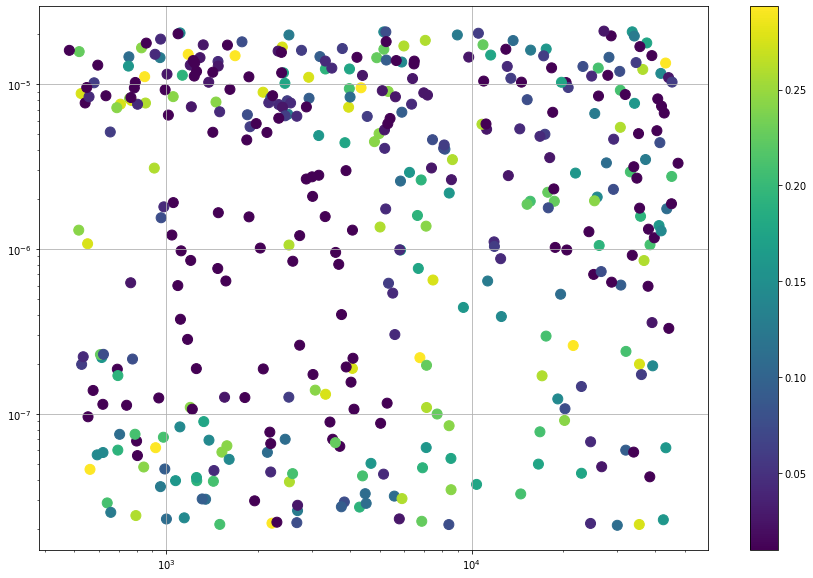

Accurace = 30%


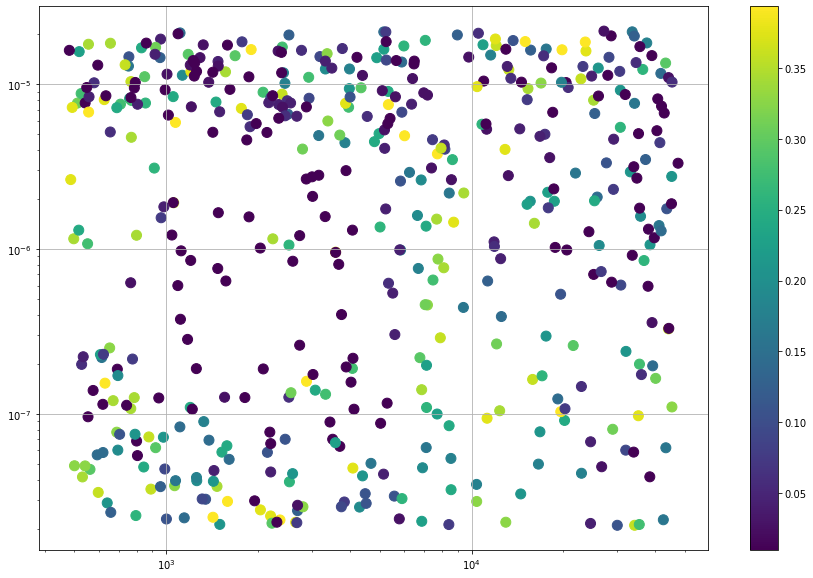

Accurace = 40%


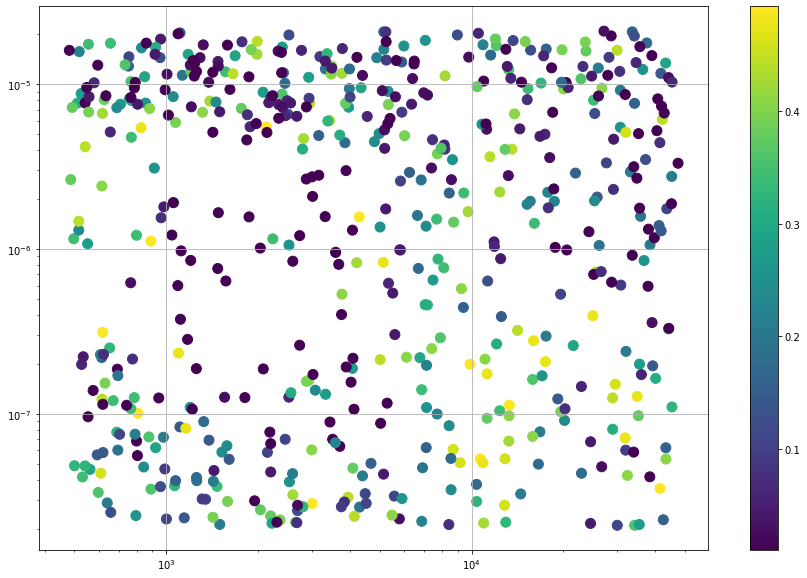

Accurace = 50%


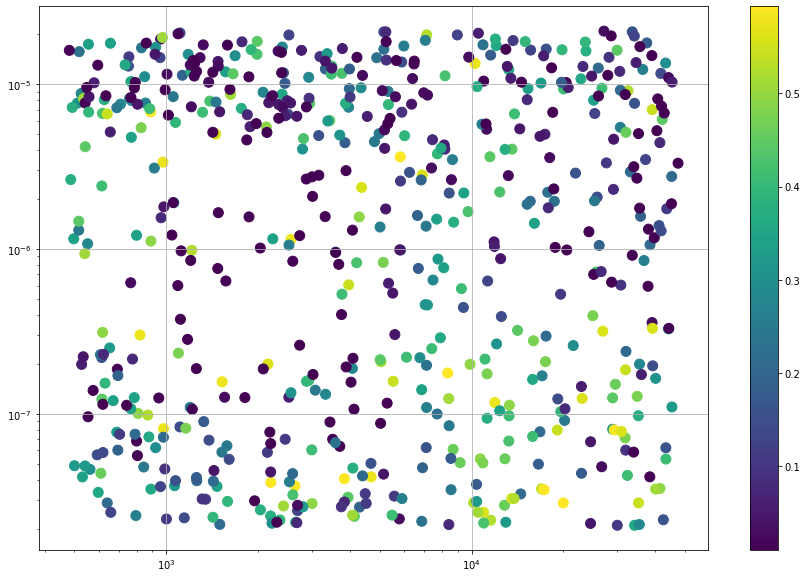

Accurace = 60%


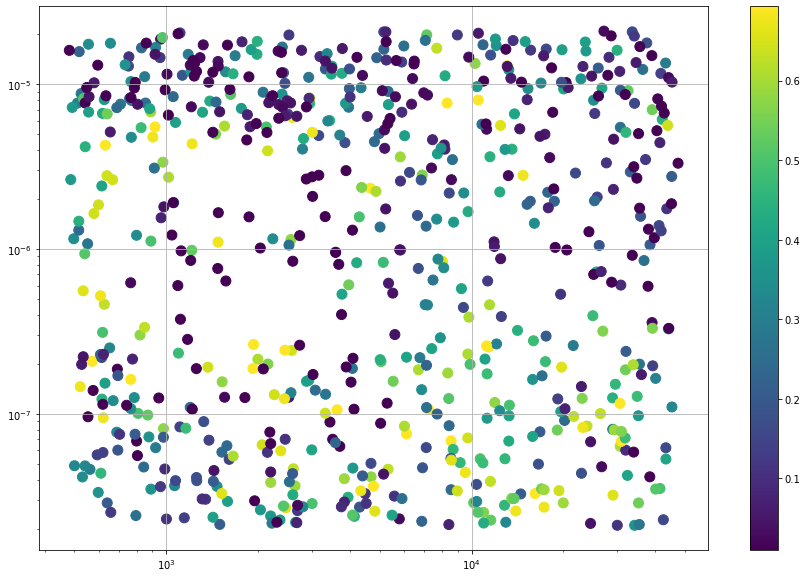

Accurace = 70%


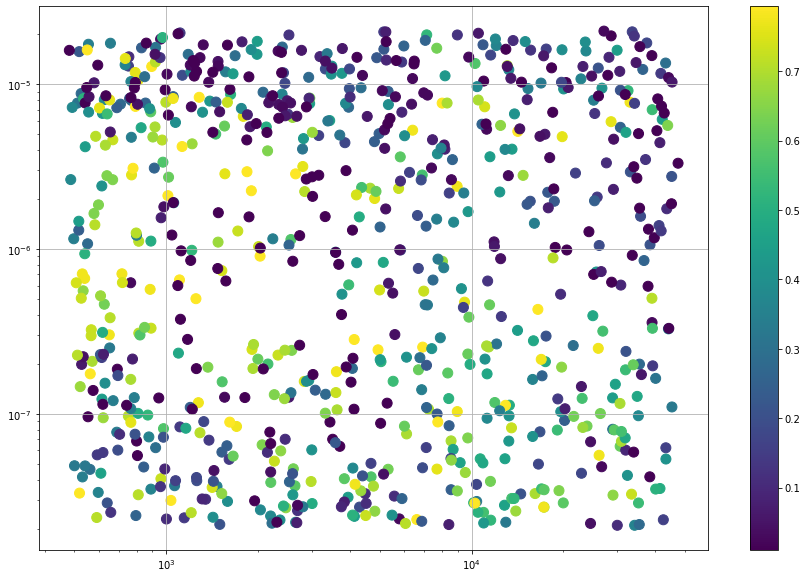

Accurace = 80%


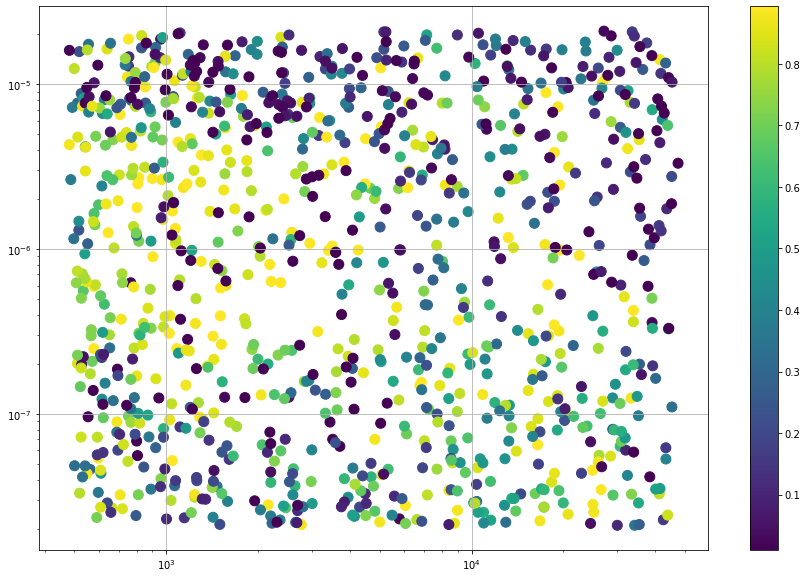

Accurace = 90%


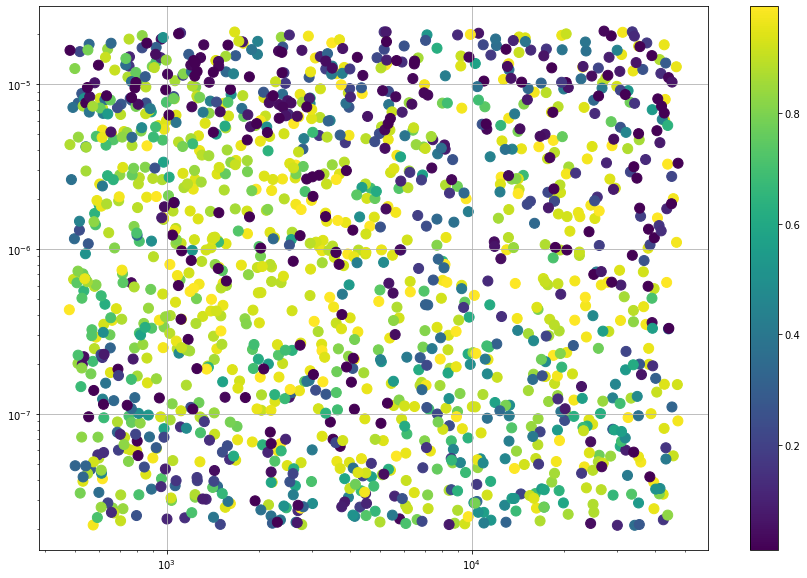

In [ ]:
for ac in range(1,10,1):
  print(f"Accurace = {ac*10}%")  
  General_acc_err1 = []
  General_param_errR1 = []
  General_param_errC1 = []
  for i in range(len(General_acc_err)):
    if General_acc_err[i] <= (ac+1)/10:
      General_acc_err1.append(General_acc_err[i])
      General_param_errR1.append(General_param_errR[i])
      General_param_errC1.append(General_param_errC[i])
  fig = plt.figure(figsize=(15, 10))
  ax = fig.add_subplot(1, 1, 1)
  #ax.set_facecolor("yellow")
  colors = np.array(General_acc_err1)
  S = np.array(General_acc_err1)
  plt.grid(True)
  plt.scatter(np.array(General_param_errR1), np.array(General_param_errC1),s=100, c=colors, alpha=1)
  #plt.scatter(np.array(General_param_errR), np.array(General_param_errR),s =S*1000, c=colors, alpha=0.3)
  plt.colorbar()
  ax.set_yscale('log')
  ax.set_xscale('log')

  plt.show()

In [ ]:
classs=[]
for j, dir in enumerate(glob.glob('/content/main_dir/val/*')):
            for name in glob.glob(dir+""):
               parts = name.split('/')
               print(parts[4], end=' - ')
               print(j)
               #print('\n')
               classs.append(parts[4])

In [ ]:
Err_par(dir='CR1',items=100)

In [ ]:
def see (xy,i ):
  
  X = xy[i][0][0][:].tolist()
  Y = xy[i][0][1][:].tolist()
  fig, ax = plt.subplots()
  
  # print(X)
  # print(Y)

  #print(list(X))
  #print(type((X[1])))
  plt.grid(True)
  ax.plot(X,Y)
  plt.show()

In [ ]:
classs=[]
for j, dir in enumerate(glob.glob('/content/Eval/*')):
            for name in glob.glob(dir+""):
               parts = name.split('/')
               print(parts[3], end=' - ')
               print(j)
               #print('\n')
               classs.append(parts[3])
               

In [ ]:
classs=[]
for j, dir in enumerate(glob.glob('/content/main_dir/val/*')):
            for name in glob.glob(dir+""):
               parts = name.split('/')
               print(parts[4], end=' - ')
               print(j)
               #print('\n')
               classs.append(parts[4])
               

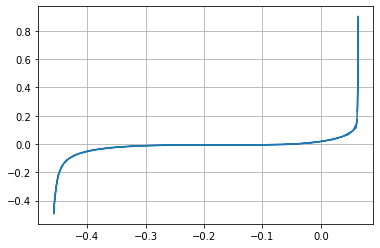

2
Получено: DDCR Ответ: D




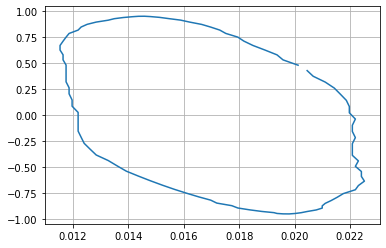

4
Получено: DDC Ответ: C




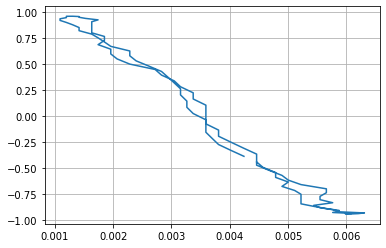

6
Получено: CD Ответ: R




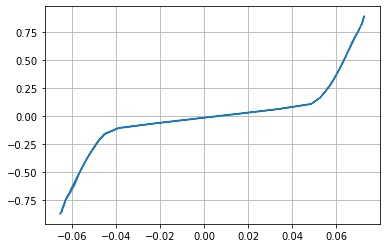

7
Получено: R Ответ: DDR




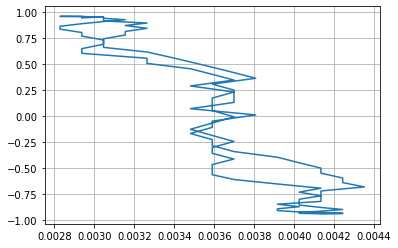

8
Получено: CRD4 Ответ: R




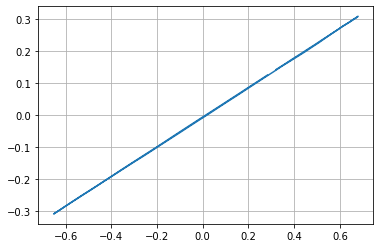

9
Получено: DDR Ответ: R




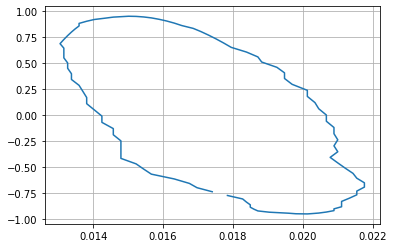

13
Получено: DDC Ответ: C




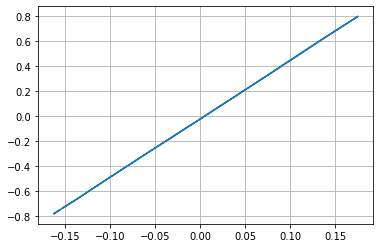

14
Получено: DDR Ответ: R




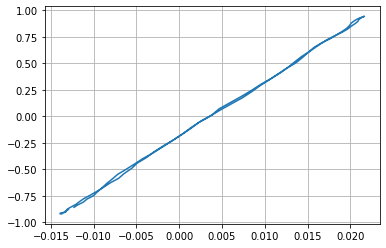

15
Получено: DDC Ответ: CRD4




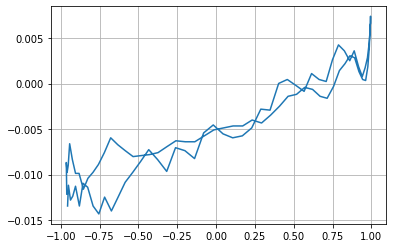

17
Получено: CR1 Ответ: C




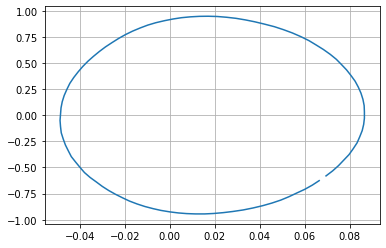

19
Получено: CR1 Ответ: C




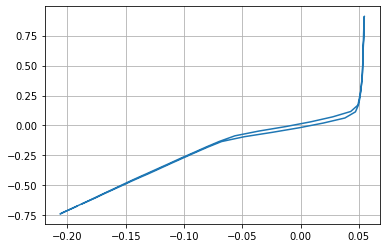

21
Получено: DR1 Ответ: DDCR


0.7338518518518519
0.7260518518518518
0.44


In [ ]:
loss_function = nn.CrossEntropyLoss()
loss1=0
i = 0
for xy, labels in Eval_loader: # get bacth
            
            # with torch.no_grad():
            #   for xy, labels in testloader:
            #     #xy, labels = xy.cuda(), labels.cuda()
            #     outputs = model(xy)
            #     _, predicted = torch.max(outputs.data, 1)
            #     total += labels.size(0)
            #     correct += (predicted == labels).sum().item()






            #xy, labels = xy.cuda(), labels.cuda()
            #print(labels)
            
            
            outputs = model(xy)
            # print((xy[0]))
            # print((xy[0][0][0][:].tolist()))
            # print('\n')
            #print(outputs)
            max_elements, max_idxs =  torch.max(outputs.data, 1)
            j = int(max_idxs[0])
            #print(max_elements)
            #print(max_idxs)
            # 
            for i in range(23):
              if max_idxs[i] != labels[i]:
                see(xy,i)
                print(i)
                #print(classs)
                print("Получено: "+classs[max_idxs[i]], "Ответ: "+classs[labels[i]])
                print('\n')

# print(loss1)
print((validate(model, train_loader)))
print((validate(model, val_loader)))# 7 bp 8
print((validate(model, Eval_loader)))

In [ ]:
def Testing (name, v=1):
    #print(glob.glob(data_dir))
      
    with open(name) as file:

      fig, ax = plt.subplots()
      line = file.readlines()
      x = line[0].split(sep = ";")
      X = list(map(float,x))
      y = line[2].split(sep = ";")
      Y = list(map(float,y))
      param = line[4].split(sep = ";")
      param = list(map(float,param))
      
      # length = len(X)
      # shift = random.randrange(1, length, 1)
      # X = X[-shift:] + X[:-shift]
      # Y = Y[-shift:] + Y[:-shift]
      
      ax.plot(X,Y)
      plt.grid(True)
      # plt.ylim([0, 100])
      # plt.xlim([0, 5])
      plt.show()

      X = np.array(X)
      Y = np.array(Y)
      xy_t = []
      xy_t = np.array((X,Y))
      Normx =(12)
      Normy =(12/4750)

      xy_t[1] = xy_t[1] / Normy
      xy_t[0] = xy_t[0] / Normx
      
    
      # fig, ax = plt.subplots()
      # ax.plot(X/ Norm,Y/ Norm)
      # plt.grid(True)
      # plt.show()


      #print(xy_t)
      xy_test = transforms((xy_t).astype(np.float32))
      # print(xy_test)
      # print(xy_test.shape)

      #see(xy_test)
      outputs = model(xy_test)
      #print('\n')
      #print(outputs)
      max_elements, max_idxs = torch.max(outputs, dim=1)
      i = int(max_idxs[0])
      #print(i)
      # print(max_elements)
      #print('\n')
      Xm = (abs(max(X)) + abs(min(X)))/2
      Ym = (abs(max(Y)) + abs(min(Y)))/2
      print(param[0:2],end ='\n')
      print(classs[i])
      
      # if i== 2:
      #   if Y[0]<0:  # Проверка на сдвиг по фазе
      #     # print(Y[0])
      #     print("Это конденсатор вот характеристики:")
      #     #print("A = %.2e   B = %.2e" % (Xm, Ym))
      #     #print('\n')
      #     C = Ym/(Xm*2*3.1415*v)
      #     print("C = %.3eF" % (C))
      #   else:
      #     print("Это катушка вот характеристики:")
      #     #print("A = %.2e   B = %.2e" % (Xm, Ym))
      #     #print('\n')
      #     L = Xm/(Ym*2*3.1415*v)
      #     print("L = %.3eH" % (L))
      # else:
      #     if i == 0:
      #       print("Это резистор вот характеристики:")
      #       #print("A = %.2e   B = %.2e" % (Xm, Ym))
      #       #print('\n')
      #       R = Xm/Ym
      #       print("R = %.3e Om" % (R))
      #     else:
      #       if i == 1:
      #         print("Это диод вот характеристики:")
      #         for i in range(100):
      #           if Y[i]> Ym/50 and X[i]>0:
      #             print("Напряжение открытия = %.3eВ" % (X[i]))
      #             break
      #         # print("B = %.2e" % (Ym))
      #         # print('\n')
      #         # L = Xm/(Ym*2*3.1415*v)
      #         # print("L = %.3eH" % (L))

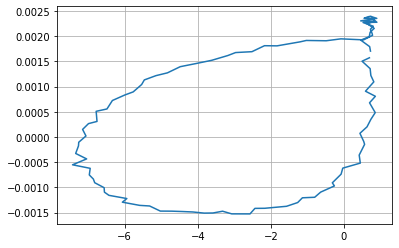

[23615.09001593984, 4.5241533777093905e-07]
DDCR


In [ ]:
Testing('/content/main_dir/val/DDCR/DDCR_4_1_3.txt', )

In [ ]:
Testing('/content/DDC1.txt', )

In [ ]:
Testing('/content/CR11.txt', )

In [ ]:

# a =[1,2,3,4,5,6]
# with open("файл.txt", "w") as file:
#     print(*a, file=file,sep=';',end='\n\n')
#     print(*a, file=file,sep=';')

In [ ]:
# length = len(a)
# lst = [1,2,3,4,5,6]
# shift = 6
# lst = lst[-shift:] + lst[:-shift]

# print(lst)

In [ ]:
for j, dir in enumerate(glob.glob('/content/main_dir/val/*')):
            for name in glob.glob(dir+"/*"):
               print(j)
               print(name)
               print('\n')

In [ ]:
# for i, dir in enumerate(glob.glob('/content/Untitled Folder*')):
#             for name in glob.glob(dir+"/*"):
              
              
#               with open(name) as file:
#                 line = file.readlines()
#                 x = line[0].split(sep = ";")
#                 X = list(map(float,x))
#                 y = line[2].split(sep = ";")
#                 Y = list(map(float,y))
#                 Ym = (abs(max(Y)) + abs(min(Y)))/2
#                 print(Ym)
#                 print(name)
#                 print('\n')

In [ ]:
80*"*"